## Query to get to get 5 yr forward and backward counts with CPC codes for biotechnology. 

In [138]:
QUERY = """
SELECT app.patent_id, app.date as publication_date, filterData.bkwdCitations_5, filterData.fwrdCitations_5, patent.title, summary.uuid--patent.abstract, summary.text as summary
FROM
  `patents-public-data.patentsview.brf_sum_text` as summary,
  `patents-public-data.patentsview.patent` as patent,
  `patents-public-data.patentsview.application` as app,
  (SELECT DISTINCT cpc.patent_id, IFNULL(citation_5.bkwdCitations_5, 0) as bkwdCitations_5, IFNULL(citation_5.fwrdCitations_5, 0) as fwrdCitations_5
  FROM
    `patents-public-data.patentsview.cpc_current` AS cpc
    LEFT JOIN
    (SELECT  b.patent_id, b.bkwdCitations_5, f.fwrdCitations_5
      FROM 

        (SELECT 
          cited.patent_id,
          COUNT(*) as fwrdCitations_5
          FROM 
          `patents-public-data.patentsview.uspatentcitation` AS cited,
          `patents-public-data.patentsview.application` AS apps
        WHERE
          apps.country = 'US'
          AND cited.patent_id = apps.patent_id 
          AND cited.date >= apps.date AND SAFE_CAST(cited.date AS DATE) <= DATE_ADD(SAFE_CAST(apps.date AS DATE), INTERVAL 5 YEAR) -- get in 5year interval 
         GROUP BY 
         cited.patent_id) AS f,

       (SELECT 
          cited.patent_id,
          COUNT(*) as bkwdCitations_5
          FROM 
          `patents-public-data.patentsview.uspatentcitation` AS cited,
          `patents-public-data.patentsview.application` AS apps
        WHERE
          apps.country = 'US'
          AND cited.patent_id = apps.patent_id 
          AND cited.date < apps.date AND SAFE_CAST(cited.date AS DATE) >= DATE_SUB(SAFE_CAST(apps.date AS DATE), INTERVAL 5 YEAR) -- get in 5year interval 
         GROUP BY 
         cited.patent_id) AS b
      WHERE
      b.patent_id = f.patent_id AND b.bkwdCitations_5 IS NOT NULL AND f.fwrdCitations_5 IS NOT NULL) AS citation_5 
      ON cpc.patent_id=citation_5.patent_id
      WHERE
       (cpc.subsection_id IN ('C05', 'C07', 'C08', 'C09', 'C11', 'C12', 'C13', 'C25', 'C40')
        OR cpc.group_id in ('A01G', 'A01H', 'A61K', 'A61P', 'A61Q', 'B01F', 'B01J', 'B81B', 'B82B', 'B82Y','G01N', 'G16H')))
  as filterData
  WHERE
  app.patent_id = filterData.patent_id AND summary.patent_id = app.patent_id AND app.patent_id = patent.id 
"""

## Set up environments for google big query python SDK

In [139]:
from google.cloud import bigquery
import os
import pandas as pd 
API_KEY_PATH = "/Users/jideofor/Documents/cs397/Patents-Research-abd8b4aaf0a8.json"
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = API_KEY_PATH
PROJECT_ID = "patents-research-275923"

## Run query and generate descriptive stats

In [143]:
df = pd.read_gbq(QUERY, project_id=PROJECT_ID, dialect='standard', progress_bar_type='tqdm')



Downloading: 100%|██████████| 1103828/1103828 [01:37<00:00, 11339.00rows/s]


In [129]:
list(df)


['patent_id',
 'publication_date',
 'bkwdCitations_5',
 'fwrdCitations_5',
 'title',
 'uuid',
 'dup']

In [153]:
maskValid = (df['publication_date'] < '2014-1-1')
df['publication_date'] = pd.to_datetime(df['publication_date'], errors="coerce",format="%Y-%m-%d")
df2 = df.loc[maskValid]


In [151]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df2.astype({'bkwdCitations_5': 'int32','fwrdCitations_5': 'int32' }).dtypes
df2.describe(include='all', percentiles=[.25, .5, .75, .95,.99])


,patent_id,publication_date,bkwdCitations_5,fwrdCitations_5,title,uuid
count,991077,991077,991077.00,991077.00,991077,991077
unique,991077,13060,nan,nan,799238,991077
top,6452157,1995-06-07 00:00:00,nan,nan,Compounds,s2yf95n0zj9ru5pkxk760nhbd
freq,1,4091,nan,nan,269,1
first,NaN,1902-07-24 00:00:00,nan,nan,NaN,NaN
last,NaN,2014-03-31 00:00:00,nan,nan,NaN,NaN
mean,NaN,NaN,1.75,0.62,NaN,NaN
std,NaN,NaN,8.80,3.91,NaN,NaN
min,NaN,NaN,0.00,0.00,NaN,NaN
25%,NaN,NaN,0.00,0.00,NaN,NaN


For record keeping there are 245,192 unique observations if we eliminate all obs with 0 backwrd or fwrd citations, the real data set has 1,078,703 observation

## Get trends plot of the trends in the number of patents released since 1995

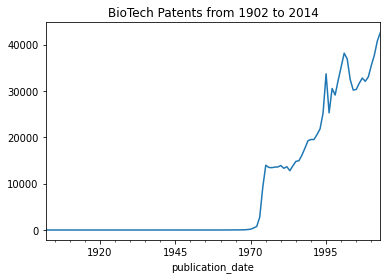

In [154]:
import matplotlib.pylab as plt

#maskEarly = (df['date'] > '1970-1-1') & (df['date'] <= '1980-1-1')
#maskLate = (df['date'] > '2010-1-1') & (df['date'] < '2016-1-1')
#maskValid = (df['date'] < '2016-1-1')

# Get the counts +
ax = df2['publication_date'].groupby(df.publication_date.dt.to_period("Y")).agg('count').plot(title="BioTech Patents from 1902 to 2014")
plt.show()


Getting the distribution of citations for two distince decades. Actually 1955-11-22 was the first year a patent got cited and backcited

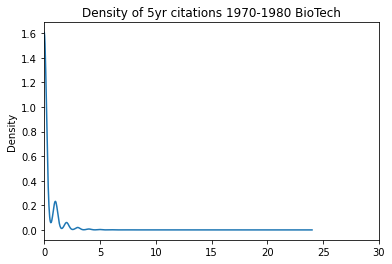

In [163]:
maskEarly = (df['publication_date'] > '1970-1-1') & (df['publication_date'] <= '1980-1-1')
df.loc[maskEarly]['fwrdCitations_5'].plot.kde(bw_method=0.3, xlim=(0,30), title="Density of 5yr citations 1970-1980 BioTech")

In [159]:
df.loc[maskEarly].describe(include='all', percentiles=[.25, .5, .75, .95,.99])



,patent_id,publication_date,bkwdCitations_5,fwrdCitations_5,title,uuid
count,81465,81465,81465.00,81465.00,81465,81465
unique,81465,2347,nan,nan,72630,81465
top,3975384,1979-12-26 00:00:00,nan,nan,Organic compounds,9zqe93hct492kqe94epttlar1
freq,1,169,nan,nan,35,1
first,NaN,1970-01-02 00:00:00,nan,nan,NaN,NaN
last,NaN,1979-12-31 00:00:00,nan,nan,NaN,NaN
mean,NaN,NaN,0.52,0.25,NaN,NaN
std,NaN,NaN,1.52,0.69,NaN,NaN
min,NaN,NaN,0.00,0.00,NaN,NaN
25%,NaN,NaN,0.00,0.00,NaN,NaN


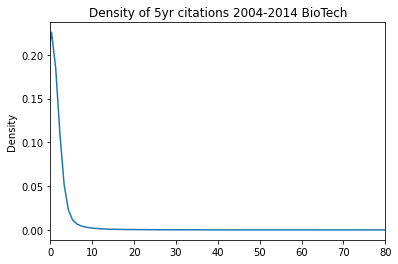

In [164]:
maskLate = (df['publication_date'] > '2004-1-1') & (df['publication_date'] < '2014-1-1')
df.loc[maskLate]['fwrdCitations_5'].plot.kde(bw_method=0.3, xlim=(0,80), title="Density of 5yr citations 2004-2014 BioTech")

In [158]:
df.loc[maskLate].describe(include='all', percentiles=[.25, .5, .75, .95,.99])



,patent_id,publication_date,bkwdCitations_5,fwrdCitations_5,title,uuid
count,346941,346941,346941.00,346941.00,346941,346941
unique,346941,3475,nan,nan,280062,346941
top,7767833,2013-03-15 00:00:00,nan,nan,Gas sensor,wcxt1vsb7r91ywbh6oz2oqpwj
freq,1,1316,nan,nan,129,1
first,NaN,2004-01-02 00:00:00,nan,nan,NaN,NaN
last,NaN,2013-12-31 00:00:00,nan,nan,NaN,NaN
mean,NaN,NaN,2.33,0.81,NaN,NaN
std,NaN,NaN,12.20,5.23,NaN,NaN
min,NaN,NaN,0.00,0.00,NaN,NaN
25%,NaN,NaN,0.00,0.00,NaN,NaN


Could be a product of the increased number of patents

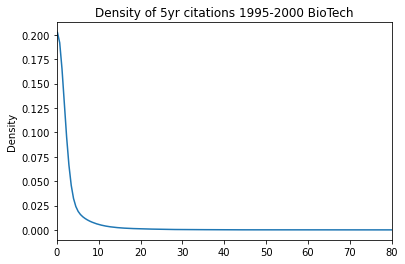

In [157]:
maskMedium = (df['publication_date'] > '1995-1-1') & (df['publication_date'] < '2000-1-1')
df.loc[maskMedium]['bkwdCitations_5'].plot.kde(bw_method=0.3, xlim=(0,80), title="Density of 5yr citations 1995-2000 BioTech")

In [113]:
df.loc[maskMedium].describe(include='all', percentiles=[.25, .5, .75, .95,.99])



,patent_id,publication_date,bkwdCitations_5,fwrdCitations_5
count,151040,151040,151040.00,151040.00
unique,151040,1531,nan,nan
top,6033862,1995-06-07 00:00:00,nan,nan
freq,1,4091,nan,nan
first,NaN,1995-01-03 00:00:00,nan,nan
last,NaN,1999-12-31 00:00:00,nan,nan
mean,NaN,NaN,1.44,0.53
std,NaN,NaN,5.53,2.02
min,NaN,NaN,0.00,0.00
25%,NaN,NaN,0.00,0.00


Saving data to gs

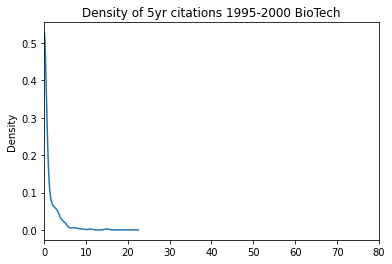

In [165]:
maskVeryLow = (df['publication_date'] < '1970-1-1')
df.loc[maskVeryLow]['bkwdCitations_5'].plot.kde(bw_method=0.3, xlim=(0,80), title="Density of 5yr citations 1995-2000 BioTech")

In [166]:
df.loc[maskVeryLow].describe(include='all', percentiles=[.25, .5, .75, .95,.99])



,patent_id,publication_date,bkwdCitations_5,fwrdCitations_5,title,uuid
count,290,290,290.00,290.00,290,290
unique,290,255,nan,nan,272,290
top,4581396,1969-10-01 00:00:00,nan,nan,Chemical agents,4tm7vyc4leqaqvmboyn0mbe1x
freq,1,3,nan,nan,14,1
first,NaN,1902-07-24 00:00:00,nan,nan,NaN,NaN
last,NaN,1969-12-29 00:00:00,nan,nan,NaN,NaN
mean,NaN,NaN,0.83,0.63,NaN,NaN
std,NaN,NaN,1.82,1.31,NaN,NaN
min,NaN,NaN,0.00,0.00,NaN,NaN
25%,NaN,NaN,0.00,0.00,NaN,NaN
